ls /bdd/PMIP3/output/IPSL/IPSL-CM5A-LR/lgm/monClim/atmos/Aclim/r1i1p1/latest/tas/tas_Aclim_IPSL-CM5A-LR_lgm_r1i1p1_260101-280012-clim.nc

In [15]:
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
import intake, intake_esm
import os
import sys
from pathlib import Path
from glob import glob
import itertools
import time
import seaborn as sns
import math
import scipy.stats as st
import requests
import pywt

import warnings
warnings.filterwarnings('ignore')

%run functions.ipynb

In [16]:
'''
Les fichiers sont stockés dans deux catalogues :
    - PMIPCat.json : Modèles Paleo
    - CMIPCat.json : Modèles Actuel (avec piControl notamment)
'''
PMIP = intake.open_esm_datastore("PMIPCat.json")

In [17]:
CMIP = intake.open_esm_datastore('CMIPCat.json')

In [18]:
'''
EPICA Dome C Coordinates
'''

lat_edc = -75.06
lon_edc = 123.2

## PMIP3

In [19]:
'''
Obtention des données 'température de l'atmosphère' du modèle pmip3 en un 
dictionnaire de dataframes.

Les étapes :
    - Appel des chemins disponibles
    - Initialisation du dictionnaire ds
    - Boucle pour créer les df :
        . Fonction readmodel (pour avoir le passage précis)
        . On réduit la zone autours d'EDC
        . On sélectionne les données souhaitées (mean, where)
        . On fait la même chose pour le lgm associé
        . On ouvre et enregistre les données en df dans ds
'''

res_lat = 1.25
res_lon = 1.75

# periods to read
#period_list = ['lgm', 'piControl']
dir_pmip3, pmip3 = PMIP3_dic()
var_def = var_dic()
period = 'piControl'
var = 'ta'

# read models

ds = {}

for model in pmip3:

    file_dir, filename = read_model(
        model, 
        'piControl',
        var_def, 
        var, 
        dir_pmip3)
    ds[model] = xr.open_mfdataset(filename)[var]
    ds[model] = zonal_reduction(ds[model], lon_edc, lat_edc , 5, 2.5)
    ds[model] = pd.DataFrame(ds[model].where(ds[model].time).mean(['time', 'lat', 'lon']).where(ds[model].plev < 70000, drop = True), index = ds[model].plev[ds[model].plev < 70000], columns = [period])
    if 'lgm' in pmip3[model]['period']:
        file_dir, filename = read_model(
            model,
            'lgm',
            var_def, 
            var,
            dir_pmip3)
        inter = xr.open_mfdataset(filename)[var]
        inter = zonal_reduction(inter, lon_edc, lat_edc , 5, 2.5)
        ds[model]['lgm'] = pd.DataFrame(inter.mean(['time', 'lat', 'lon']).where(inter.plev < 70000, drop = True), index = inter.plev[inter.plev < 70000])

Reading ta CNRM-CM5 for piControl
Reading ta CNRM-CM5 for lgm
Reading ta COSMOS-ASO for piControl
Reading ta COSMOS-ASO for lgm
Reading ta IPSL-CM5A-LR for piControl
Reading ta IPSL-CM5A-LR for lgm
Reading ta FGOALS-g2 for piControl
Reading ta FGOALS-g2 for lgm
Reading ta MIROC-ESM for piControl
Reading ta MIROC-ESM for lgm
Reading ta MPI-ESM-P for piControl
Reading ta MPI-ESM-P for lgm
Reading ta MRI-CGCM3 for piControl
Reading ta MRI-CGCM3 for lgm
Reading ta GISS-E2-R for piControl
Reading ta GISS-E2-R for lgm
Reading ta CCSM4 for piControl
Reading ta CCSM4 for lgm


In [20]:
'''
Même chose que la cellule précédente mais pour la variable tas et ps
'''

var = ['tas', 'ps']
dates = ['piControl', 'lgm']

ds2 = {}

for model in pmip3 :
    ds_inter = {}
    for  d in dates :
        file_dir, filename = read_model(model, d, var_def, var[1], dir_pmip3)
        ps = xr.open_mfdataset(filename)[var[1]]
        ps = zonal_reduction(ps, lon_edc, lat_edc , 5, 2.5)
        ps = float(ps.mean(['time', 'lat', 'lon']))
        
        file_dir, filename = read_model(model, d, var_def, var[0], dir_pmip3)
        tas = xr.open_mfdataset(filename)[var[0]]
        tas = zonal_reduction(tas, lon_edc, lat_edc , 5, 2.5)
        tas = float(tas.mean(['time', 'lat', 'lon']))

        ds_inter[d] = {'plev' : ps, 'tas' : tas}
          
    ds2[model] = ds_inter

Reading ps CNRM-CM5 for piControl
Reading tas CNRM-CM5 for piControl
Reading ps CNRM-CM5 for lgm
Reading tas CNRM-CM5 for lgm
Reading ps COSMOS-ASO for piControl
Reading tas COSMOS-ASO for piControl
Reading ps COSMOS-ASO for lgm
Reading tas COSMOS-ASO for lgm
Reading ps IPSL-CM5A-LR for piControl
Reading tas IPSL-CM5A-LR for piControl
Reading ps IPSL-CM5A-LR for lgm
Reading tas IPSL-CM5A-LR for lgm
Reading ps FGOALS-g2 for piControl
Reading tas FGOALS-g2 for piControl
Reading ps FGOALS-g2 for lgm
Reading tas FGOALS-g2 for lgm
Reading ps MIROC-ESM for piControl
Reading tas MIROC-ESM for piControl
Reading ps MIROC-ESM for lgm
Reading tas MIROC-ESM for lgm
Reading ps MPI-ESM-P for piControl
Reading tas MPI-ESM-P for piControl
Reading ps MPI-ESM-P for lgm
Reading tas MPI-ESM-P for lgm
Reading ps MRI-CGCM3 for piControl
Reading tas MRI-CGCM3 for piControl
Reading ps MRI-CGCM3 for lgm
Reading tas MRI-CGCM3 for lgm
Reading ps GISS-E2-R for piControl
Reading tas GISS-E2-R for piControl
Reading

In [21]:
'''
Mise en commun de ds et ds2

On ajoute les donénes de surface de ds2 dans les tableaux du
dictionnaire ds.
'''

for model in pmip3 :
    for d in dates :
        inter = pd.DataFrame(
            [ds2[model][d]['tas']], 
            columns = [d], 
            index = [ds2[model][d]['plev']]
            )
        
        ds[model] = ds[model].append(inter)

## PMIP4

In [23]:
'''
Pour lire les données précédemment entregistrées (voir Temperature_gradient.ipynb).
Il contient la température atmosphérique (ta) par niveau de pression pour chaque
modèle et chaque période (piControl, LGM, lig127k) dans le PMIP4
'''

df = pd.read_csv(
    '/home/bchaigneau/Stage_LSCE/datas/df_grad_ta', 
    sep = ' ', 
    names = ['ta', 'plev', 'institute', 'source', 'period', 'grid'],
    skiprows = 1
    )
#df.plev = df.plev.astype(float)

In [24]:
'''
Depuis le df on ne sélectionne que ce qui nous intéresse :
    - les modèles qui run le LGM
    - les données de pression inférieur à 700 hPa
    
On reshape finalement le tableau
'''

lgm_source = df[df['period'] == 'lgm']['source'].unique()

df_selec = df[(df['source'].isin(lgm_source)) & (df['period'] != 'lig127k') & (df['plev'] < 70000)]
df_selec = pd.pivot_table(df_selec, values = 'ta', index = ['source','period', 'plev']).reset_index()

In [25]:
'''
Objectif: aller chercher la température de surface associée à sa pression de surface
dans les modèles PMIP4.

Les étapes :
    - On assigne les variables
    - Création d'un df vide qui sera rempli
    - Pour chaque modèle, si le chemin existe pour le piControl et le LGM alors :
        . On attribue deux listes vides (pour les futures données piControl et LGM)
        . On importe depuis les CMIP les deux variables (tas & ps)
        . Sélection del a zone autours d'EDC
        . Moyenne dans le temps et l'espace
        . On met les données dans les listes vides
        
        . Même chose pour les PMIP
        
    - On créer des df pour chaque liste remplie et on l'ajoute au df commun du début
'''

var = ['tas', 'ps']
inst = PMIP.df['institution_id'].unique()
source = PMIP.df['source_id'].unique()
date = 'lgm'

df_surf = pd.DataFrame(
    columns = [
        'source',
        'period',
        'plev',
        'ta'
        ])

for i in inst :
    for s in source :
        if os.path.exists(
            ('/bdd/CMIP6/CMIP/{}/{}/piControl/r1i1p1f1/Amon/ps/gn/latest'.format(i, s))
        ) and ( os.path.exists('/bdd/CMIP6/PMIP/{}/{}/{}/r1i1p1f1/Amon/ps/gn/latest'.format(i, s, date))) :
            lst_pi = []
            lst_old = []
            for v in var :
                # piControl
                X = CMIP.search(
                    institution_id= '{}'.format(i), 
                    variable_id = v,
                    source_id = '{}'.format(s),
                    table_id = 'Amon', 
                    experiment_id= 'piControl',  
                    latest = True,  
                    member_id = "r1i1p1f1",
                    grid_label = 'gn'
                    )
                ds_pi = xr.open_mfdataset(
                    list(X.df["path"]),
                    chunks = 100,
                    use_cftime=True,
                    decode_cf=True
                    )[v][:1000]
                ds_pi = ds_pi.where((
                    (ds_pi["lat"] > lat_edc - 2.5) 
                    & (ds_pi['lat'] < lat_edc + 2.5) 
                    & (ds_pi['lon'] > lon_edc - 5) 
                    & (ds_pi['lon'] < lon_edc + 5)),
                    drop=True
                    )
                ds_pi = ds_pi.mean(['time', 'lat', 'lon'])

                print('Computing piControl for : {} - {} :'.format(s, v))
                with ProgressBar():
                    ds_pi = ds_pi.compute()
                lst_pi.append(float(ds_pi))


                # LGM 
                X = PMIP.search(
                    institution_id= '{}'.format(i), 
                    variable_id = v,
                    source_id = '{}'.format(s),
                    table_id = 'Amon', 
                    experiment_id= date,  
                    latest = True,  
                    member_id = "r1i1p1f1",
                    grid_label = 'gn'
                    )
                ds_old = xr.open_mfdataset(
                    list(X.df["path"]),
                    chunks = 100,
                    use_cftime=True,
                    decode_cf=True
                    )[v][:1000]
                ds_old = ds_old.where((
                    (ds_old.coords["lat"] > lat_edc - 2.5) 
                    & (ds_old.coords['lat'] < lat_edc + 2.5) 
                    & (ds_old.coords['lon'] > lon_edc - 5) 
                    & (ds_old.coords['lon'] < lon_edc + 5)),
                    drop=True
                    )
                ds_old = ds_old.mean(['time', 'lat', 'lon'])

                print('Computing {} for : {} - {} :'.format(date, s, v))
                with ProgressBar():
                    ds_old = ds_old.compute()               
            
                lst_old.append(float(ds_old))
            
    
            data = pd.DataFrame()
            data['ta'] = pd.Series(lst_pi[0])
            data['plev'] = pd.Series(lst_pi[1])
            data['period'] = 'piControl'
            data['source'] = s
            df_surf = df_surf.append(data)

            data = pd.DataFrame()
            data['ta'] = pd.Series(lst_old[0])
            data['plev'] = pd.Series(lst_old[1])
            data['period'] = 'lgm'
            data['source'] = s
            df_surf = df_surf.append(data)


Computing piControl for : MPI-ESM1-2-LR - tas :
[########################################] | 100% Completed |  1.2s
Computing lgm for : MPI-ESM1-2-LR - tas :
[########################################] | 100% Completed |  1.0s
Computing piControl for : MPI-ESM1-2-LR - ps :
[########################################] | 100% Completed |  1.0s
Computing lgm for : MPI-ESM1-2-LR - ps :
[########################################] | 100% Completed |  1.0s
Computing piControl for : AWI-ESM-1-1-LR - tas :
[########################################] | 100% Completed |  1.6s
Computing lgm for : AWI-ESM-1-1-LR - tas :
[########################################] | 100% Completed |  1.4s
Computing piControl for : AWI-ESM-1-1-LR - ps :
[########################################] | 100% Completed |  1.7s
Computing lgm for : AWI-ESM-1-1-LR - ps :
[########################################] | 100% Completed |  1.7s


In [26]:
'''
Mise en commun de la température de surface et atmosphérique
'''

df_selec = df_selec.append(df_surf)

## PLOT Gradient T°

### PMIP4

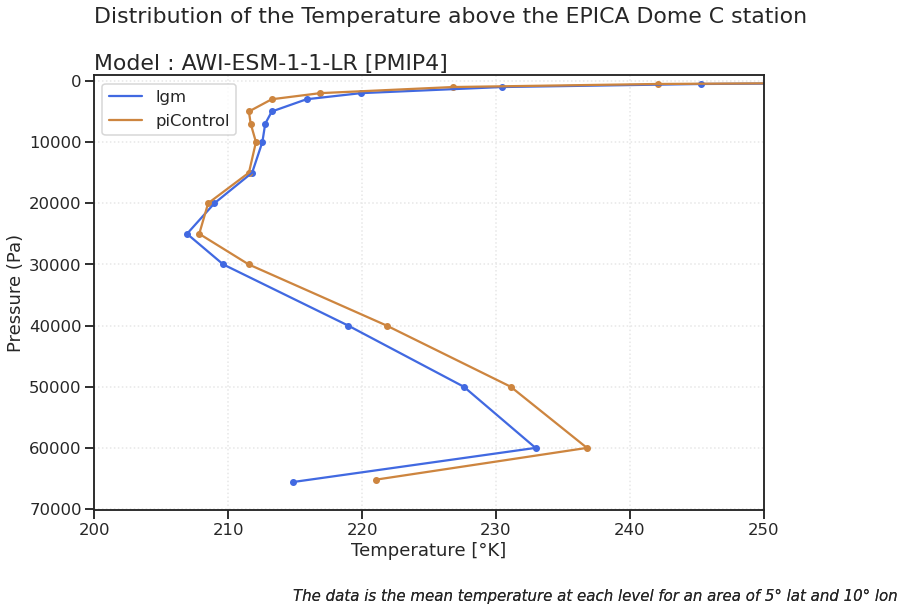

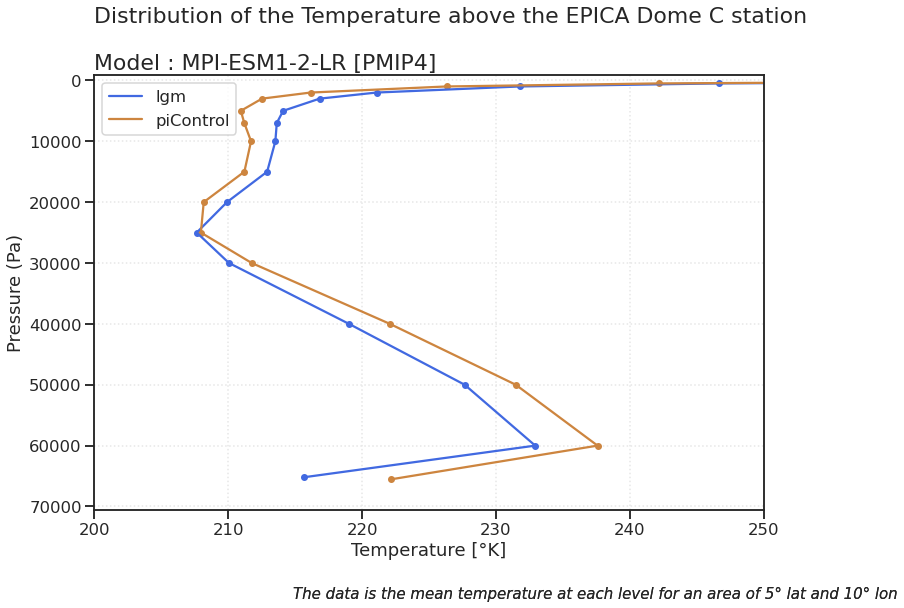

In [27]:
'''
Plot du gradient de températue selon les niveaux de pression
pour les modèles PMIP4

Les étapes :
    - Initialisation des couleurs, styles et périodes étudiées
    - Pour chaque modèle :
        . Sélection des périodes une par une
        . Plot 
        . Ajout des points de données (scatter)
        . On défini l'esthétique (xlim, ylim, xlabel, ylabel, titre, textes)
        . On enregistre
'''

colors = {
    'piControl':'peru', 
    'lgm':'royalblue', 
    'lig127k':'forestgreen'
    }

periods = [
    'piControl',
    'lgm'
    ]

sns.set_context("talk")
sns.set_style('ticks')
sns.set_context("talk") 
sns.set_style(
    'ticks', 
    {"grid.color":"0.9", 
     "grid.linestyle":":", 
     "axes.grid": True
    })

for s in df_selec['source'].unique():
    fig, ax = plt.subplots(figsize = (12, 8))
    for p in df_selec.period.unique() :
        df_inter = df_selec[(df_selec['source'] == s) & (df_selec['period'] == p)]

        plt.plot(
            df_inter.ta, 
            df_inter.plev, 
            c = colors[p],
            label = p
        )
        plt.scatter(df_inter.ta, df_inter.plev,
                   c = colors[p],
                   s = 30
                   )
        plt.ylim(
            max(df_inter.plev + 5000), 
            min(df_inter.plev - 1000)
            )
        plt.xlim(
            200,
            250
            )
        plt.xlabel('Temperature [°K]')
        plt.ylabel('Pressure (Pa)')
        plt.title(
            'Distribution of the Temperature above the EPICA Dome C station\n\nModel : {} [PMIP4]'.format(s), 
            size = 22,
            loc = 'left'
            )
        plt.text(260, 85000, 
                 'The data is the mean temperature at each level for an area of 5° lat and 10° lon',
                 fontstyle = 'italic',
                 horizontalalignment = 'right',
                 fontsize = 15
                )
    plt.legend()
    plt.savefig('/home/bchaigneau/Stage_LSCE/plot/gradient_edc/PMIP4_{}_ta.jpeg'.format(s),
                dpi= 100, 
                bbox_inches = 'tight', 
                pad_inches = 1)
    plt.show()

### PMIP3

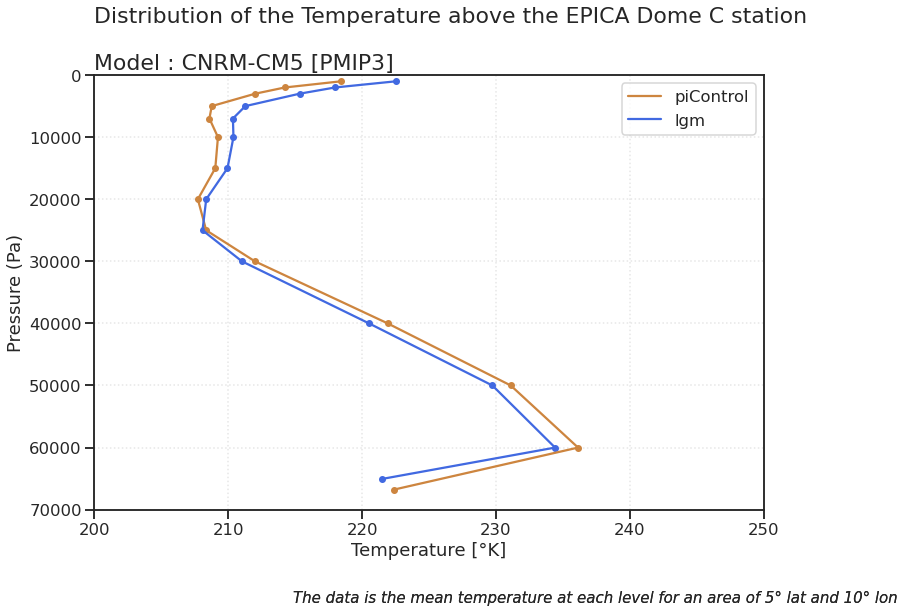

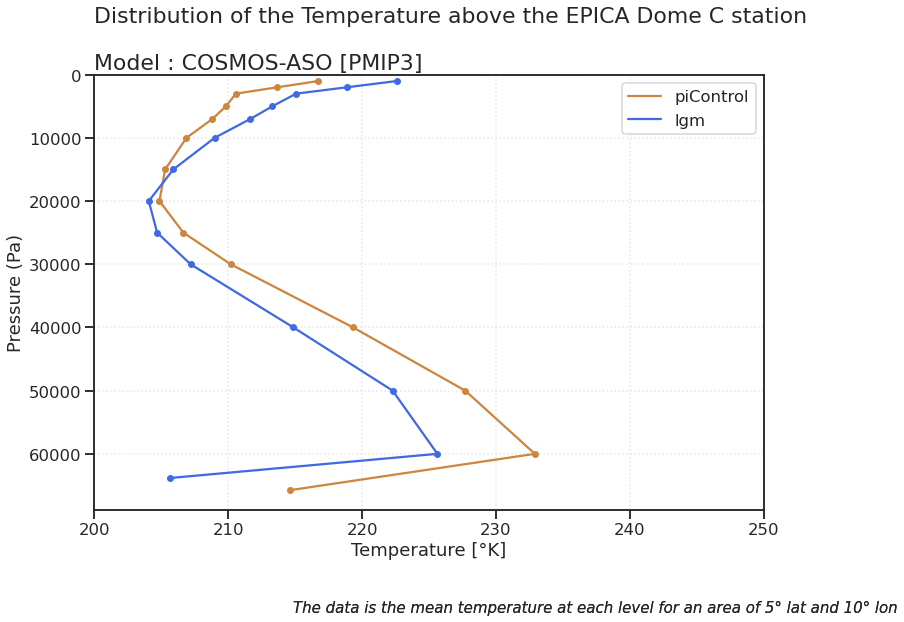

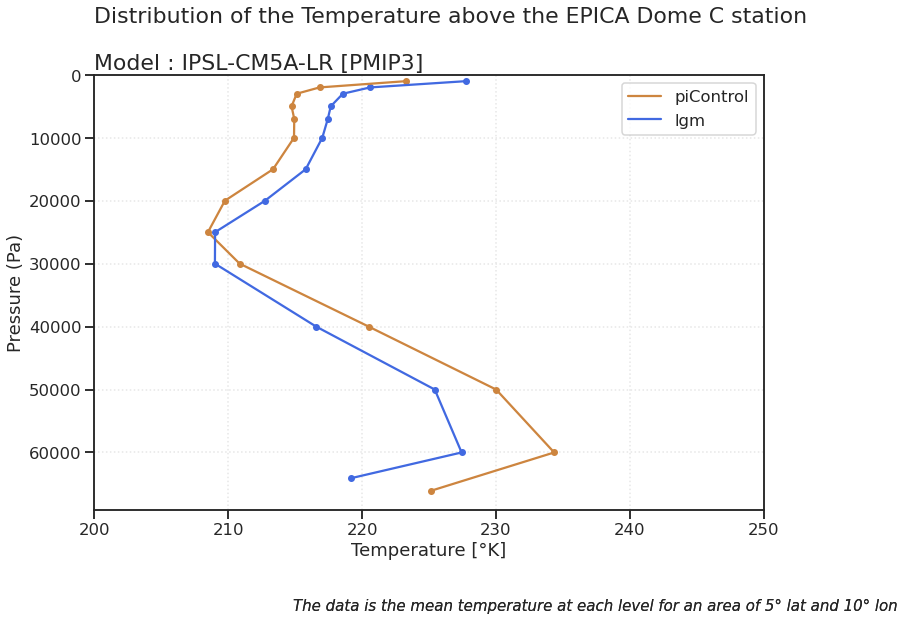

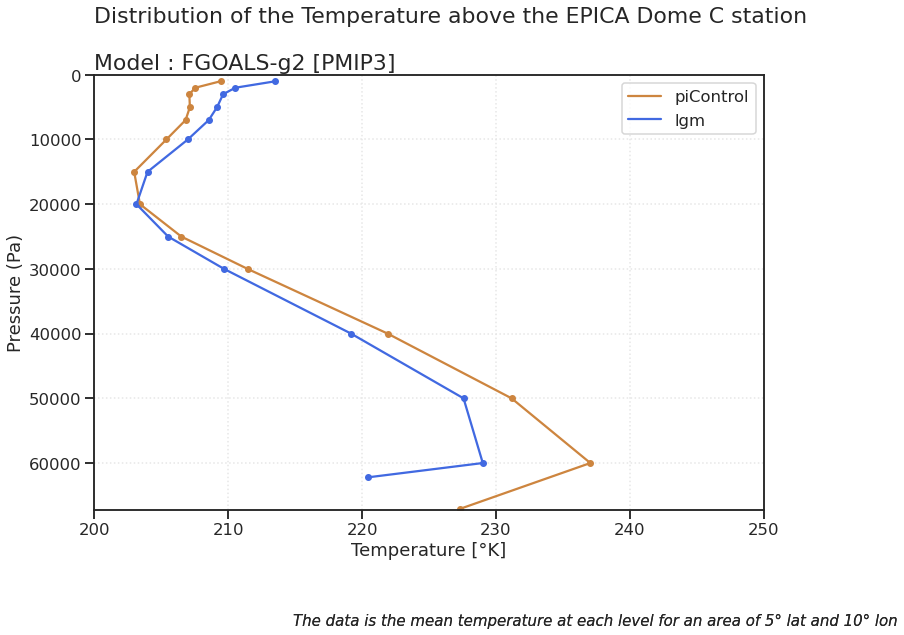

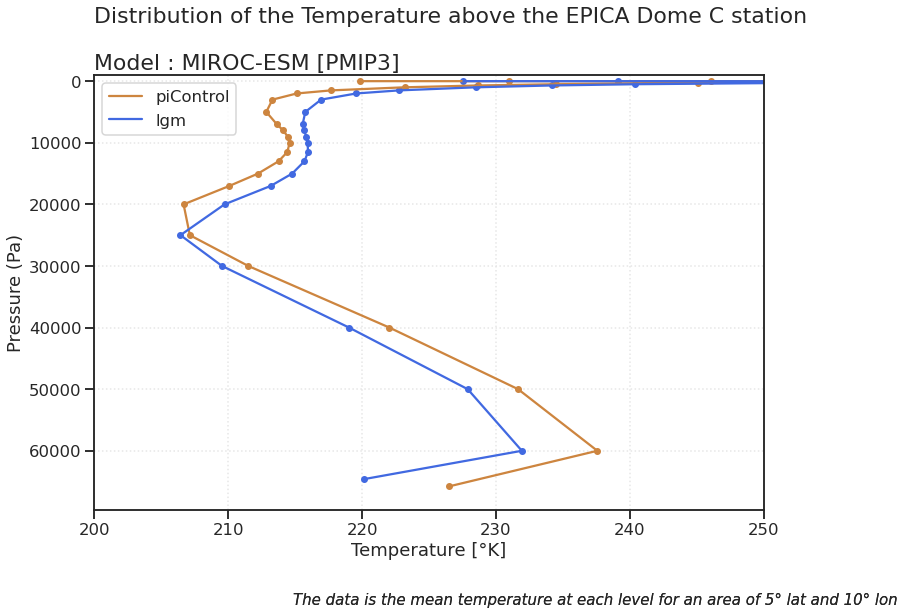

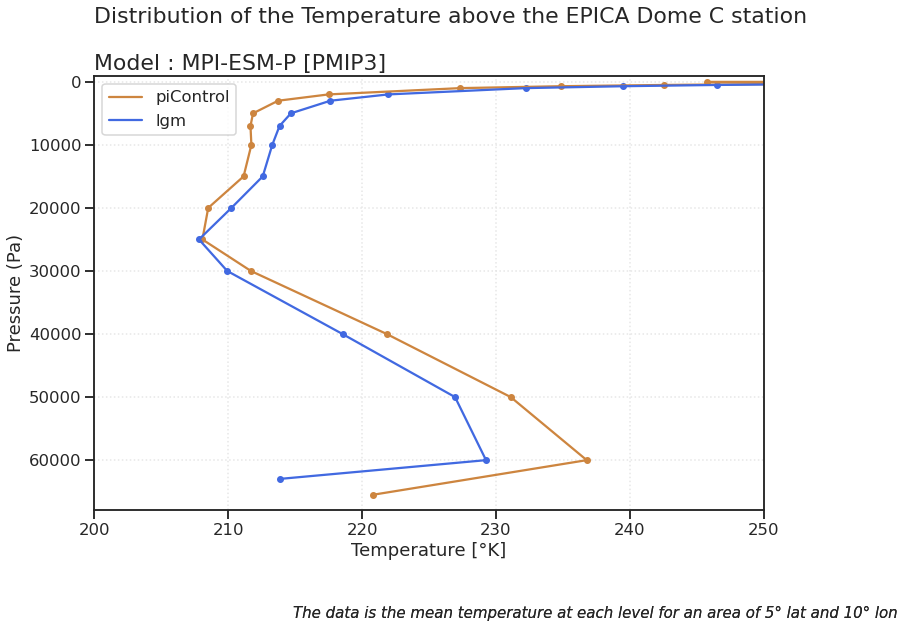

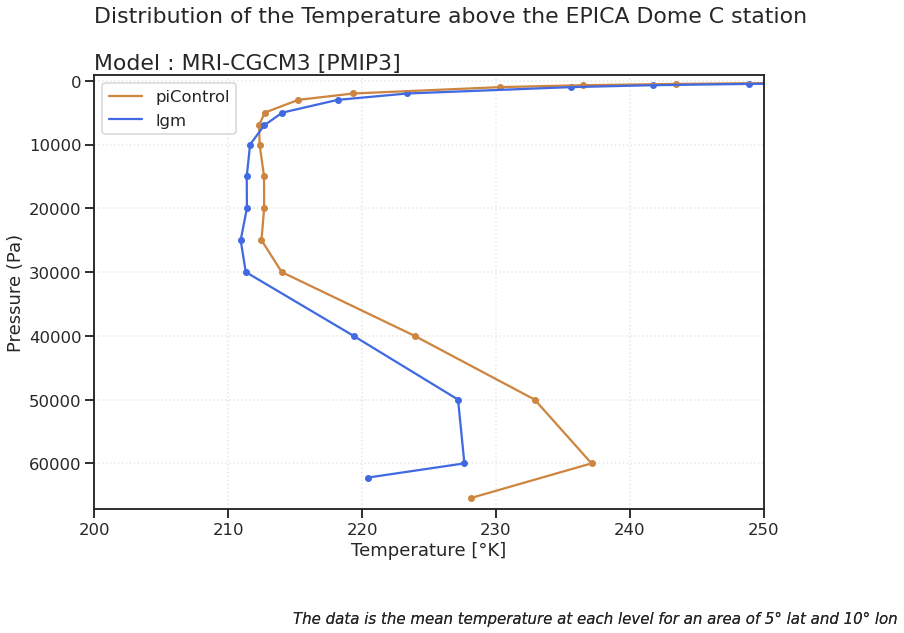

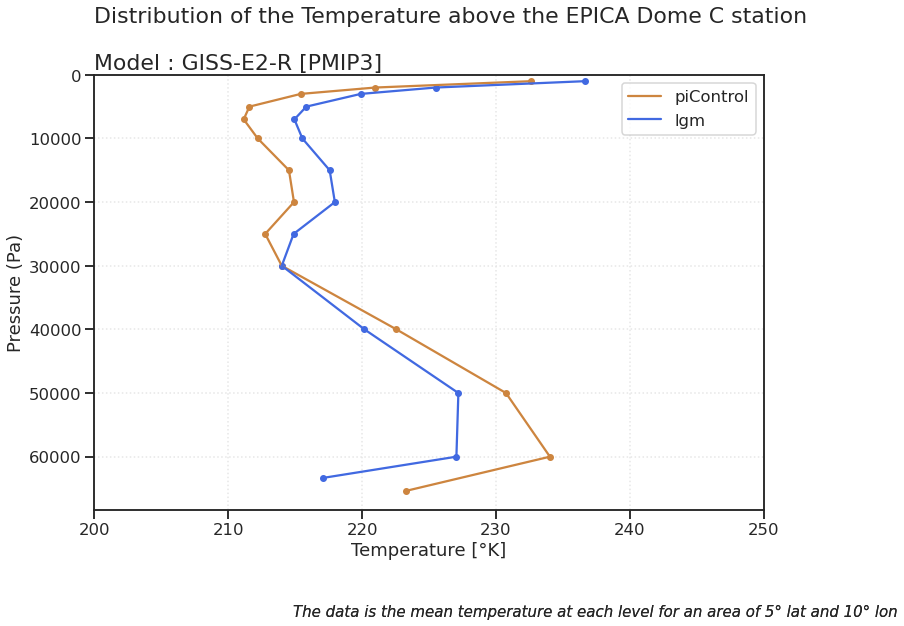

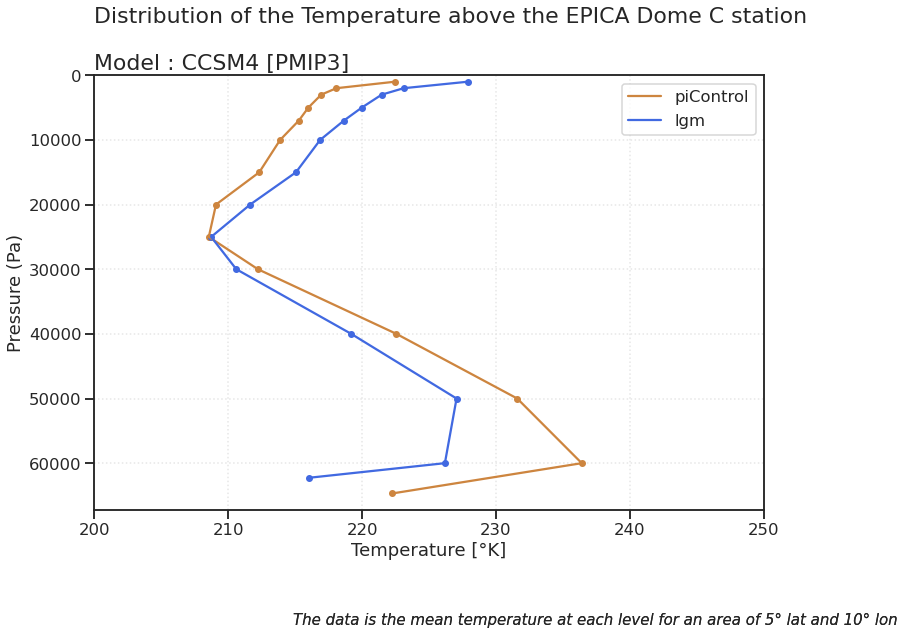

In [34]:
'''
Plot du gradient de températue selon les niveaux de pression
pour les modèles PMIP3

Les étapes :
    - Initialisation des styles
    - Pour chaque modèle (ds.item):
        . Sélection des périodes une par une (p)
        . Tricks de sélection des données
        . Plot
        . Ajout des points de données (scatter)
        . On défini l'esthétique (xlim, ylim, xlabel, ylabel, titre, textes)
        . On enregistre
'''


sns.set_context("talk")
sns.set_style('ticks')
sns.set_context("talk") 
sns.set_style(
    'ticks', 
    {"grid.color":"0.9", 
     "grid.linestyle":":", 
     "axes.grid": True
    })

for k, v in ds.items() :
    fig, ax = plt.subplots(figsize = (12, 8))
    for p in v.columns : 
        v_inter = v[p].dropna().sort_index(ascending = True)
        plt.plot(v_inter, v_inter.index,
                c = colors[p],
                label = p
                )
        plt.scatter(v_inter, v_inter.index,
                   c = colors[p],
                   s = 30
                   )
        plt.ylim(
            max(v_inter.index + 5000), 
            min(v_inter.index - 1000)
            )
        plt.xlim(
            200,
            250
            )
        plt.xlabel('Temperature [°K]')
        plt.ylabel('Pressure (Pa)')
        plt.title(
            'Distribution of the Temperature above the EPICA Dome C station\n\nModel : {} [PMIP3]'.format(k), 
            size = 22,
            loc = 'left'
            )
        plt.text(260, 85000, 
                 'The data is the mean temperature at each level for an area of 5° lat and 10° lon',
                 fontstyle = 'italic',
                 horizontalalignment = 'right',
                 fontsize = 15
                )
    plt.legend()
    plt.savefig('/home/bchaigneau/Stage_LSCE/plot/gradient_edc/PMIP3_{}_ta.jpeg'.format(k),
                dpi= 100, 
                bbox_inches = 'tight', 
                pad_inches = 1)
    plt.show()

In [28]:
df_selec

,source,period,plev,ta
0,AWI-ESM-1-1-LR,lgm,100.000000,278.759600
1,AWI-ESM-1-1-LR,lgm,500.000000,245.338710
2,AWI-ESM-1-1-LR,lgm,1000.000000,230.418400
3,AWI-ESM-1-1-LR,lgm,2000.000000,219.906860
4,AWI-ESM-1-1-LR,lgm,3000.000000,215.852800
...,...,...,...,...
59,MPI-ESM1-2-LR,piControl,60000.000000,237.585660
0,MPI-ESM1-2-LR,piControl,65539.914062,222.155533
0,MPI-ESM1-2-LR,lgm,65191.714844,215.683578
0,AWI-ESM-1-1-LR,piControl,65202.328125,221.009293


### Buizert data

In [29]:
'''
Papier de Buizert : https://hal.archives-ouvertes.fr/hal-03249154/document

On reprend ses données et on met sous forme de df
'''

dTc_buizert = -5
dTs_buizert = -4.3

dTcdTs_buizert = dTc_buizert / dTs_buizert

#buizert = pd.DataFrame(dTcdTs_buizert, index = ['Buizert'], columns = ['dTc/dTs'])
buizert = pd.DataFrame(
    [dTc_buizert, dTs_buizert], 
    index = ['dTc', 'dTs'],
    columns = ['Buizert']
    ).T

#### PMIP4 df : dTc/dTs

In [30]:
selec = df_selec[(df_selec['plev'] == 50000) | (df_selec['plev'] > 60000)]
selec['plev'] = np.where((selec.plev > 60000), 65000, selec.plev)

pmip4_dTc_dTs = pd.pivot_table(
    selec, 
    values = 'ta',
    index = ['source'],
    columns = 'plev',
    aggfunc = np.diff
    )
pmip4_dTc_dTs = abs(pmip4_dTc_dTs) * -1

pmip4_dTc_dTs

plev,50000.0,65000.0
source,,
AWI-ESM-1-1-LR,-3.50236,-6.133453
MPI-ESM1-2-LR,-3.81525,-6.471954


In [31]:
selec = df_selec[(df_selec['plev'] == 50000) | (df_selec['plev'] > 60000)]
selec['plev'] = np.where((selec.plev > 60000), 65000, selec.plev)

selec = pd.pivot_table(
    selec, 
    values = 'ta',
    index = ['source', 'plev'],
    aggfunc = np.diff
    )

selec.ta = abs(selec.ta) * -1
selec = pd.pivot_table(selec, values = 'ta', columns = 'plev', index = 'source')
selec['dTc/dTs'] = selec[50000]/selec[65000]
selec['model'] = 'PMIP4'
df_pmip4 = selec.drop(columns = [50000, 65000])

## Figure dTcdTs / Modèles

In [32]:
inver_df = pd.DataFrame(columns = ['dTc/dTs']) 

for k, v in ds.items():

    selec = v[(v.index == 50000) | (v.index > 60000)]
    Tc = selec.iloc[0]
    dTc = Tc.lgm - Tc.piControl
    Ts = selec.iloc[1:3,:].mean(axis = 0)
    dTs = Ts.lgm - Ts.piControl
    dTcdTs =  dTc / dTs
    inter_df = pd.DataFrame(data = [dTcdTs], 
                            index = [k], 
                            columns = ['dTc/dTs']
                           )
    inver_df = inter_df.append(inver_df)

buizert_dTcdTs = pd.DataFrame(dTcdTs_buizert, index = ['Buizert'], columns = ['dTc/dTs'])
inver_df['model'] = 'PMIP3'

inver_df = buizert_dTcdTs.append(inver_df)
inver_df = inver_df.fillna('Buizert')

inver_df = df_pmip4.append(inver_df)

In [44]:
inver_df

,dTc/dTs,model
AWI-ESM-1-1-LR,0.571026,PMIP4
MPI-ESM1-2-LR,0.589505,PMIP4
Buizert,1.162791,Buizert
CCSM4,0.722966,PMIP3
GISS-E2-R,0.572028,PMIP3
MRI-CGCM3,0.738815,PMIP3
MPI-ESM-P,0.599126,PMIP3
MIROC-ESM,0.594919,PMIP3
FGOALS-g2,0.525580,PMIP3
IPSL-CM5A-LR,0.768527,PMIP3


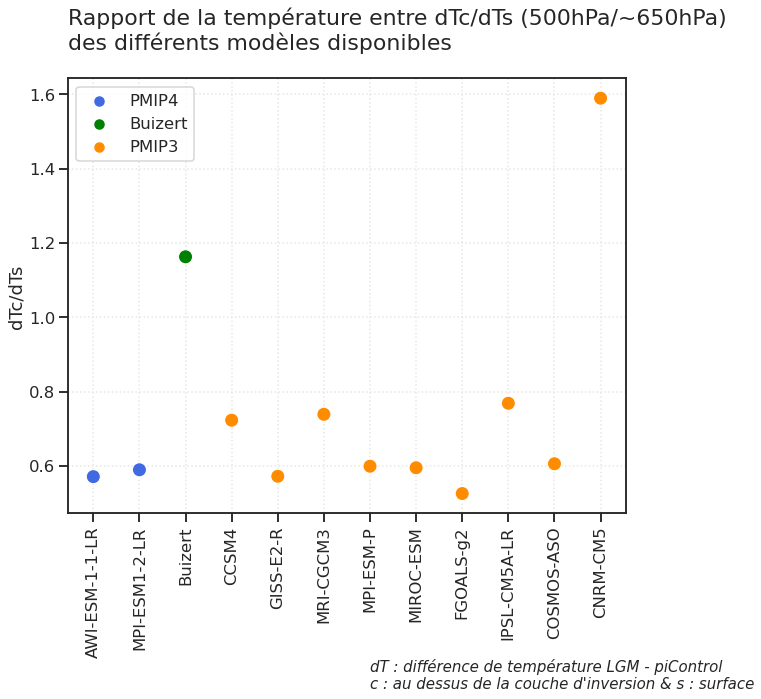

In [33]:
sns.set_context("talk")
sns.set_style('ticks')
sns.set_context("talk") 
sns.set_style(
    'ticks', 
    {"grid.color":"0.9", 
     "grid.linestyle":":", 
     "axes.grid": True
    })

fig, ax = plt.subplots(figsize = (10,8))
# colors = {'PMIP3' : 'royalblue', 'PMIP4' : 'green', Buizert : 'darkorange'}

sns.scatterplot(
    data = inver_df,
    x = inver_df.index, y = inver_df['dTc/dTs'],
    hue = inver_df.model,
    palette = ['royalblue', 'green', 'darkorange'],
    s = 200
    )
plt.xticks(rotation=90)
plt.title(
    "Rapport de la température entre dTc/dTs (500hPa/~650hPa)\ndes différents modèles disponibles\n",
    loc = 'left',
    fontsize = 22
    )
plt.ylabel('dTc/dTs')
plt.text(6, 0,
         "dT : différence de température LGM - piControl\nc : au dessus de la couche d'inversion & s : surface",
        fontstyle = 'italic',
        fontsize = 15,
        horizontalalignment = 'left')
ax.legend()
plt.savefig(
    '/home/bchaigneau/Stage_LSCE/plot/gradient_edc/inversion/PMIP3_dTcdTs_models.jpeg',
    dpi= 100,
    bbox_inches = 'tight',
    pad_inches = 1.1
    )

## Figure dTc/dTs

In [45]:
inver_df = pd.DataFrame(columns = ['dTc', 'dTs']) 

for k, v in ds.items():

    selec = v[(v.index == 50000) | (v.index > 60000)]
    Tc = selec.iloc[0]
    dTc = Tc.lgm - Tc.piControl
    
    Ts = selec.iloc[1:3,:].mean(axis = 0)
    dTs = Ts.lgm - Ts.piControl
    dTcdTs =  dTc / dTs
    inter_df = pd.DataFrame([dTc, dTs], index = ['dTc', 'dTs'], columns = [k]).T
    inver_df = inter_df.append(inver_df)

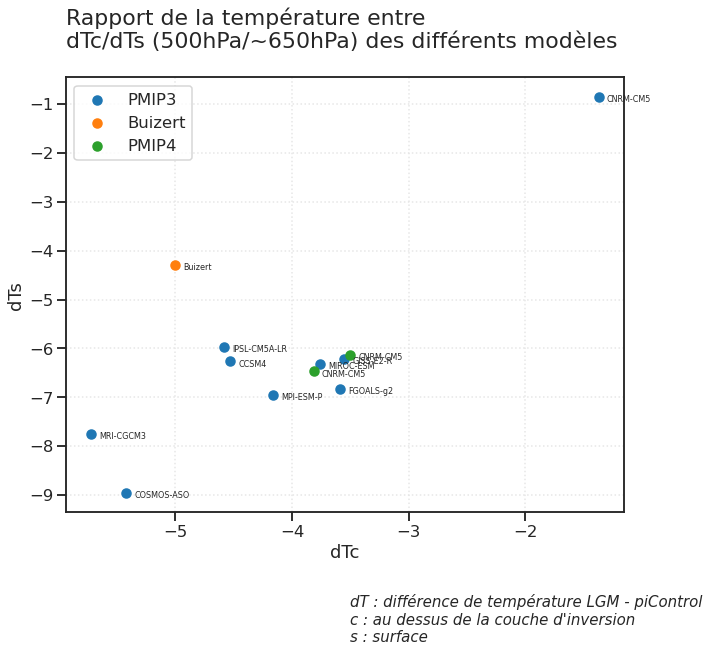

In [46]:
fig, ax = plt.subplots(figsize = (10,8))
plt.scatter(inver_df.dTc, inver_df.dTs, label = 'PMIP3')
plt.scatter(buizert.dTc, buizert.dTs, label = 'Buizert')
plt.scatter(pmip4_dTc_dTs[50000], pmip4_dTc_dTs[65000], label = 'PMIP4')

for i in inver_df.index:
    dTs = inver_df.loc[i].dTs
    dTc = inver_df.loc[i].dTc
    ax.annotate(
        i,
        (dTc + 0.07, dTs - 0.1), 
        size = 8
        )
ax.annotate(
    'Buizert', 
    (dTc_buizert + 0.07, dTs_buizert - 0.1),
    size = 8
    )
for x in pmip4_dTc_dTs.index :
    dTs = pmip4_dTc_dTs.loc[x][65000]
    dTc = pmip4_dTc_dTs.loc[x][50000]
    ax.annotate(i, (dTc + 0.07, dTs - 0.1), size = 8) 

plt.ylabel('dTs')
plt.xlabel('dTc')

plt.text(-3.5, -12,
         "dT : différence de température LGM - piControl\nc : au dessus de la couche d'inversion\ns : surface",
        fontstyle = 'italic',
        fontsize = 15,
        horizontalalignment = 'left')

plt.legend()

plt.title(
    "Rapport de la température entre\ndTc/dTs (500hPa/~650hPa) des différents modèles\n",
    loc = 'left',
    fontsize = 22
    )

plt.savefig(
    '/home/bchaigneau/Stage_LSCE/plot/gradient_edc/inversion/PMIP3_dTc_dTs.jpeg',
    dpi= 100,
    bbox_inches = 'tight',
    pad_inches = 1.1
    )

# PLOT Ts / Tc

###     ERA 5 Data

In [47]:
tas = xr.open_dataset('/home/bchaigneau/Stage_LSCE/datas/ERA_tas_EDC.nc')['t2m']
tas = tas.mean(['latitude', 'longitude', 'time'])
Ts_era = float(tas)
print(Ts_era)
ta = xr.open_dataset('/home/bchaigneau/Stage_LSCE/datas/ERA_ta_EDC.nc')['t']
ta = ta.mean(['latitude', 'longitude', 'time'])
Tc_era = float(ta)
print(Tc_era)

224.15274047851562
232.6879119873047


In [48]:
TsTc = pd.DataFrame()
TsTc['Ts'] = [Ts_era]
TsTc['Tc'] = [Tc_era]
TsTc['model'] = 'ERA5'
TsTc['source'] = 'ERA5'
TsTc['period'] = 'present'

In [49]:
pmip4_ts = df_selec[df_selec['plev'] > 60000][['source', 'period','ta']]
pmip4_ts['model'] = 'PMIP4'
pmip4 = pmip4_ts.rename(columns = {'ta':'Ts'}, inplace = False)

pmip4_tc = df_selec[df_selec['plev'] == 50000][['source', 'period','ta']]
pmip4_tc = pmip4_tc.rename(columns = {'ta':'Tc'}, inplace = False)
pmip4 = pd.merge(pmip4_tc, pmip4, how = 'outer')

TsTc = TsTc.append(pmip4)

In [50]:
pmip3 = pd.DataFrame() 

for k, v in ds.items():

    selec = v[(v.index == 50000) | (v.index > 60000)]
    Tc = selec.iloc[0]
    Ts = selec.iloc[1:3,:].mean(axis = 0)
        
    dates = ['lgm', 'piControl']
    for d in dates : 
        
        inter = pd.DataFrame()
        inter['Tc'] = pd.Series(Tc[d])
        inter['model'] = 'PMIP3'
        inter['source'] = k
        inter['period'] = d
        inter['Ts'] = pd.Series(Ts[d])
        pmip3 = pmip3.append(inter)

TsTc = TsTc.append(pmip3)
TsTc = TsTc.reset_index(drop = True)

In [51]:
x = pd.DataFrame()
x['Ts'] = [273.15 - 59.77]
x['Tc'] = [Tc_era - 0.65*7.78]
x['model'] = 'Buizert'
x['source'] = 'Buizert'
x['period'] = 'lgm'


TsTc = TsTc.append(x)

x = pd.DataFrame()
x['Ts'] = [273.15 - 55.44]
x['Tc'] = [Tc_era]
x['model'] = 'Buizert'
x['source'] = 'Buizert'
x['period'] = 'present'

TsTc = TsTc.append(x)

In [53]:
TsTc

,Ts,Tc,model,source,period
0,224.152740,232.687912,ERA5,ERA5,present
1,214.875839,227.598790,PMIP4,AWI-ESM-1-1-LR,lgm
2,221.009293,231.101150,PMIP4,AWI-ESM-1-1-LR,piControl
3,215.683578,227.662980,PMIP4,MPI-ESM1-2-LR,lgm
4,222.155533,231.478230,PMIP4,MPI-ESM1-2-LR,piControl
5,221.507477,229.735611,PMIP3,CNRM-CM5,lgm
6,222.369644,231.106171,PMIP3,CNRM-CM5,piControl
7,205.686295,222.283173,PMIP3,COSMOS-ASO,lgm
8,214.633850,227.703506,PMIP3,COSMOS-ASO,piControl
9,219.158310,225.428528,PMIP3,IPSL-CM5A-LR,lgm


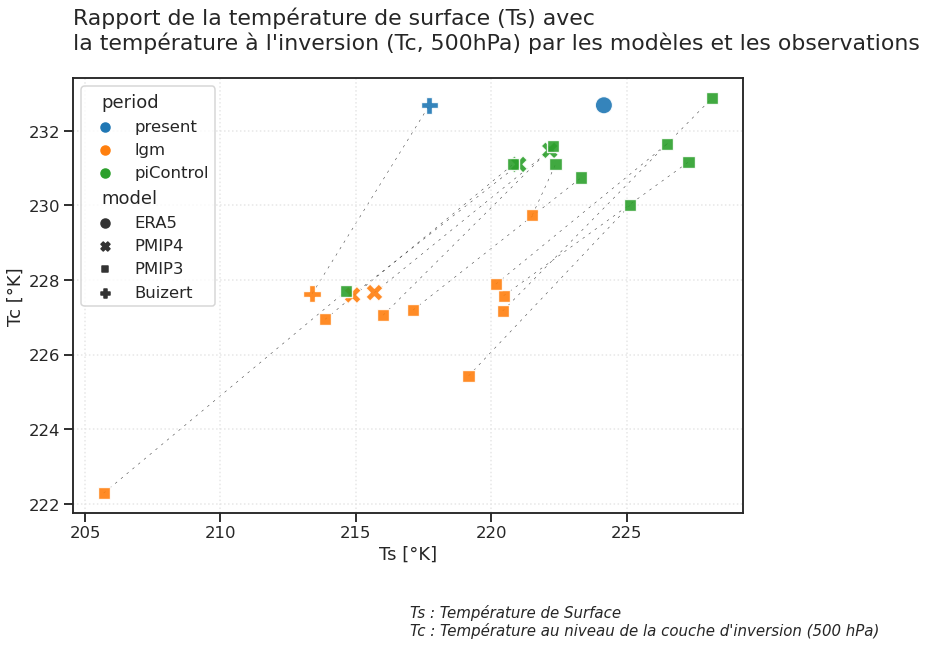

In [52]:
sns.set_context("talk")
sns.set_style('ticks')
sns.set_context("talk") 
sns.set_style(
    'ticks', 
    {"grid.color":"0.9", 
     "grid.linestyle":":", 
     "axes.grid": True
    })

fig, ax = plt.subplots(figsize = (12,8))

for i in TsTc[(TsTc['model'] != 'ERA5') & (TsTc['model'] != 'Buizert')].source.unique() :
    inter = TsTc[TsTc['source'] == i]
    plt.plot(
        inter.Ts, inter.Tc, 
        linestyle = (0, (5, 10)), linewidth = 0.5, 
        color = 'black', 
        alpha = 0.8,
        zorder = -1
        )

buiz = TsTc[TsTc['model'] == 'Buizert']
plt.plot(
    buiz.Ts, buiz.Tc, 
    linestyle = (0, (5, 10)), linewidth = 0.5, 
    color = 'black', 
    alpha = 0.8,
    zorder = -1
    )
    
sns.scatterplot(data = TsTc,
                x = 'Ts', y = 'Tc',
                hue = 'period',
                style = 'model',
                s = 300,
                alpha = 0.9
                )

#for x, r in TsTc.iterrows() :
#    ax.annotate(r['source'], (r['Ts'] + 0.3, r['Tc']), size = 6) 

plt.xlabel('Ts [°K]', fontsize = 18)
plt.ylabel('Tc [°K]', fontsize = 18)

plt.text(217, 218,
         "Ts : Température de Surface\nTc : Température au niveau de la couche d'inversion (500 hPa)\n",
        fontstyle = 'italic',
        fontsize = 15,
        horizontalalignment = 'left')
plt.title(
    "Rapport de la température de surface (Ts) avec\nla température à l'inversion (Tc, 500hPa) par les modèles et les observations\n",
    loc = 'left',
    fontsize = 22
    )

plt.savefig(
    '/home/bchaigneau/Stage_LSCE/plot/gradient_edc/inversion/Ts_Tc.jpeg',
    dpi= 100,
    bbox_inches = 'tight',
    pad_inches = 1.1
    )